Overwriting old data in P1F
Two Phase Calculations....

Vapour Phase Calculations....

Tail off Calculations....

Plotting Figures....

Figures Plotted....
N20 Mass Flow Rate: -1.3802151946966068
Final Grain Radius: 0.052
Impulse: 39484.06336


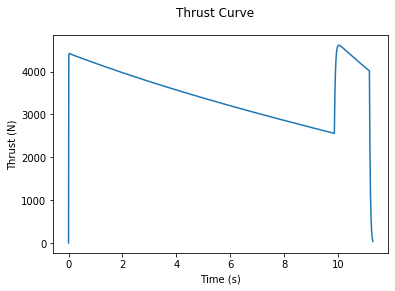

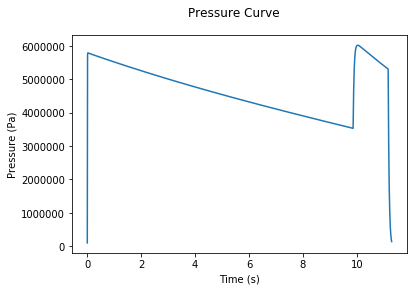

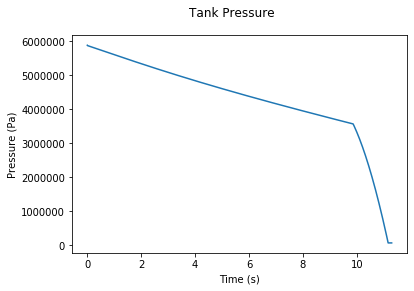

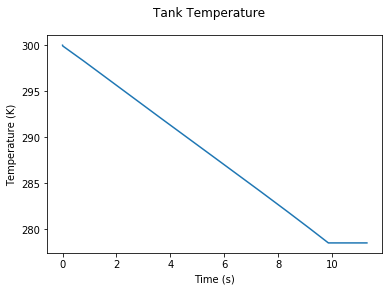

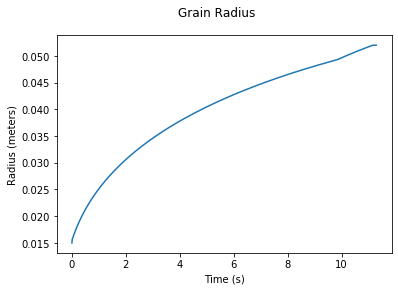

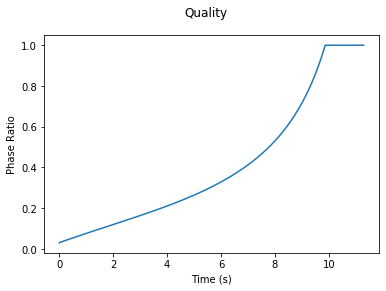

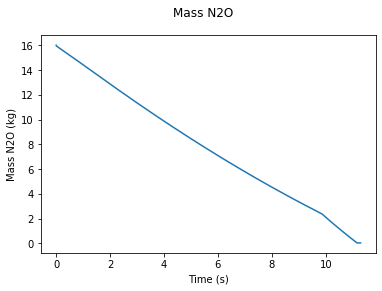

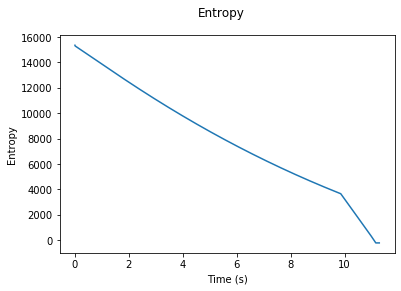

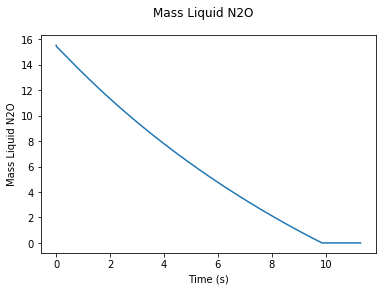

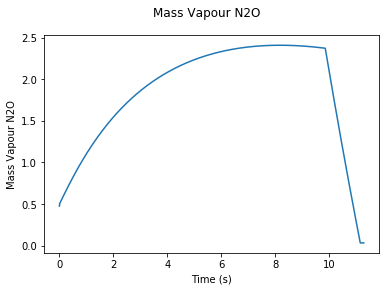

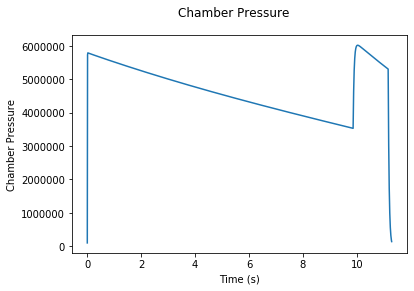

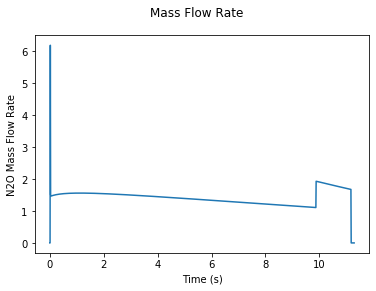

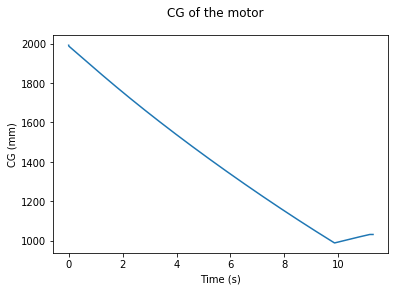

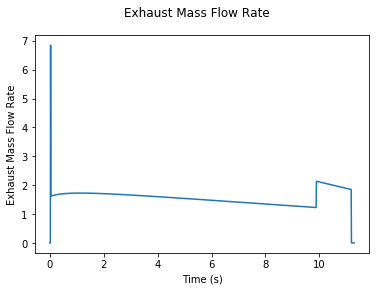

In [3]:

import math
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import integrate
import statistics
from scipy.stats import linregress
from scipy.integrate import odeint
import os
try:
    import CoolProp.CoolProp
    from CoolProp.CoolProp import PropsSI
except ImportError:
    print('Unable to load CoolProp. CoolProp files will not be imported.')

"FLAGS"

t_s = True

"INPUTS"
engine_name = "P1F"
a_l = .3
e_d = 0.1524 # Airframe internal diameter
i_d = 0.147 #Internal Motor Diameter
t_l = 0.8 # Thrust Chamber Length
# Environment
g = 9.81    #"Gravitational Acceleration, m/s^2"
Pa = 101325 #"Ambient Pressure, Pascal"
Ta = 300    #"Ambient Temperature, K

# Combustion chamber
n_cstar = 0.9     #"Combustion Efficiency"
n_cf = 0.885           #"Cf Efficiency"
k = 1.114           #"Ratio of Specific Heats with respect to combustion products"
Dint = 0.03          #"Initial Paraffin Grain Diameter, m"
Dchamber = i_d     #"Chamber Diameter, m"
pcomb = 900         #"Paraffin's density, kg/m^3"
Vol = t_l * np.pi * (i_d/2) ** 2     #"Free chamber volume, m^3"
M = 26.912            #"Molar mass of combustion products, kg/kmol"
To = 3347             #"Chamber temperature, K"
Dthroat = 26*10**-3   #"Throat Diameter, m"
Dexit =41*10**-3 #"Exit Diameter, m"
Lgrain = 0.5    #"Paraffin Grain Length, m"

# Oxidiser Tank
Cd = 0.65     #"Injector's Discharge Coefficient"
IA = 0.0002  #"Injector Area, m^2"
dox = i_d   # Diameter of oxidiser tank (m)

Cd_Vent = 0.65       # Vent's Discharge Coefficient
i_ox_mass = 16 # Initial oxidiser mass, kg
fuel_mass = (((Dchamber/2)*(Dchamber/2)) - ((Dint/2)*(Dint/2)))*3.14*Lgrain*pcomb
length_tank = 1.4# Length of oxidiser tank, m

"CG INITIAL CALCULATIONS"
tank_crosssectionalarea = (((i_d)**2)*np.pi)/4  #Internal cross-section of the tank 
#parts format  = [nozzle, inner retention rings, outer retenion rings, post combustor, chamber, thermal protection system, pre combustor
#                 top chamber bulk head, electronics and gas flow, bottom tank bulkhead, tank, top tank bulkhead]

hardware_indv_start = [0,0,0,0, 107.7, 107.7, 807.7, 907.7, 907.7, 947.7, 994.64, 1078.84, 1242.97, 1255.67, 1255.67, 1281.07, 2991.67] #mm
hardware_indv_end = [107.7, 22, 22, 947.7, 907.7, 307.7, 907.7, 912.7, 947.7, 1242.98, 1197.84, 1113.77, 1255.67, 3042.81, 1306.47, 3017.07,3042.47 ]#mm
hardware_indv_length = [107.7, 22, 22,947.7, 800, 200, 100, 5, 40, 295.28, 203.2, 34.93, 12.70, 1787.14, 50.8, 1736, 50.8] #mm
hardware_indv_mass = [3.42, 0.36, 0.25, 4.75, 3.80, 1.62, 0.70, 0.10, 1.54, 0.56, 0.73, 0.05, 0.41, 11.51, 1.07, 3.95, 1.00] #kg
hardware_indv_cg = [0.051745, 0.465, 0.70, 0.155,0.13,1.1,0.17,0.89,0.567,0.5,0.56, 0.73, 0.05, 0.41, 11.51, 1.07, 3.95] #mm
hardware_Final_indv_cg = np.add(hardware_indv_cg,hardware_indv_end)

hardware_indv_weight = np.multiply(hardware_indv_mass,g)
hardware_total_weight = np.sum(hardware_indv_weight)
hardware_cgw = np.sum(np.multiply(hardware_indv_weight, hardware_Final_indv_cg))


"STORAGE PATH SETUP"
try:
    os.mkdir("./"+engine_name)
except:
    print("Overwriting old data in "+engine_name)

try:
    os.mkdir("./"+engine_name+"/data")
except:
    pass

try:
    os.mkdir("./"+engine_name+"/images")
except:
    pass

image_path = "./"+engine_name+"/images"
data_path = "./"+engine_name+"/data"
steppeddata_filename = data_path+"/discreet.csv"
otherdata_filename = data_path+"/data.txt"
thrustcurve = data_path+"/"+engine_name+".eng"

"COMPUTED PARAMETERS"

R = 8314/M; #"Universal Gas Constant divided by Effective Molecular Mass"

VA = np.pi*(0.001**2)/4 # Vent Area, m2
gamma_vapour =  PropsSI('C','T',Ta,'Q',0,'NITROUSOXIDE')/PropsSI('CVMASS','T',Ta,'Q',0,'NITROUSOXIDE') # Specific heat ratio of vapour nitrous oxide
Vtank = np.pi*dox**2*length_tank/4; # Volume of oxidiser tank, m3

X = (PropsSI('D','T',Ta,'Q',1,'NITROUSOXIDE')*PropsSI('D','T',Ta,'Q',0,'NITROUSOXIDE')*Vtank-PropsSI('D','T',Ta,'Q',1,'NITROUSOXIDE')*i_ox_mass)/(i_ox_mass*(PropsSI('D','T',Ta,'Q',0,'NITROUSOXIDE')
-PropsSI('D','T',Ta,'Q',1,'NITROUSOXIDE'))) # Initial quality of nitrous oxide inside the tank
if X < 0:
    print("Warning: X is less than zero! Increase tank volume or decrease initial mass")
    exit()

"INITIALIZE MONITOR SOLUTIONS"

mass_nitrous = [i_ox_mass] # Available nitrous mass at each time instant, kg
mass_liquid_nitrous = [(1-X)*i_ox_mass] # Available liquid nitrous mass at each time instant, kg
mass_vapour_nitrous = [X*i_ox_mass] # Available vapour nitrous mass at each time instant, kg
temperature_tank = [Ta] # Tank temperature at each time instant, K
out_liquid_nitrous = [0] # Mass of liquid nitrous oxide that escapes through the injector, kg
out_vapour_nitrous = [0] # Mass of vapour nitrous oxide that escapes through the injector, kg
consumed_liquid = [0] # Total consumed liquid nitrous at each time instant, kg
consumed_vapour = [0] # Total consumed vapour nitrous at each time instant, kg
chamber_pressure = [Pa] # Combustion chamber pressure, Pa
grain_radius = [Dint/2] # Paraffin grain radius, m
tank_pressure = [PropsSI('P','T',Ta,'Q',X,'NITROUSOXIDE')] # Oxidiser tank pressure, Pa
total_entropy = [i_ox_mass*PropsSI('S','T',Ta,'Q',X,'NITROUSOXIDE')] # Total entropy with respect to oxidiser tank, J/K
specific_entropy = [PropsSI('S','T',Ta,'Q',X,'NITROUSOXIDE')] # Specific entropy with respect to oxidiser tank, J/kgK
overall_density = [i_ox_mass/Vtank] # Density of nitrous oxide inside the tank (considering both phases), kg/m3
quality = [X] # Quality of the satured nitrous oxide
thrust = [0] # Thrust generated by the motor, N
cf = [0] # Thrust coefficient
n2o_mass_flow_rate = [0] # N2O Mass Flow Rate
exhaust_mass_flow_rate = [0]

"CG CALCULATION FUNCTION"


def cg_calculate(both):
    
    grain_weight = ((i_d**2 - grain_radius[-1]**2)*np.pi*Lgrain) * pcomb * g #Weight of the paraffin wax
    grain_cg = Lgrain/2 #Centre of gravity of the paraffin wax  
    
    if both == 1:
        
        lnox_density=PropsSI('D','P',tank_pressure[-1],'Q',0,'NITROUSOXIDE') # Liquid nitrous oxide density
        lnox_weight = mass_liquid_nitrous[-1]*g #Weight of the liquid nitrous
        lnox_height = ((mass_liquid_nitrous[-1]/lnox_density)/tank_crosssectionalarea)
        lnox_cg = lnox_height/2 + np.sum(hardware_indv_length[0:16])#Height of liquid NOX
        
        vnox_density =PropsSI('D','P',tank_pressure[-1],'Q',1,'NITROUSOXIDE') # Vapour nitrous oxide density
        vnox_weight = mass_vapour_nitrous[-1]*g #Weight of the vapour nitrous
        vnox_height = ((mass_vapour_nitrous[-1]/vnox_density)/tank_crosssectionalarea)
        vnox_cg = vnox_height/2 + lnox_height #Height of Vapour Nox
        
        weight_total = lnox_weight + vnox_weight + grain_weight + hardware_total_weight #Total weight  
        all_cgw = (lnox_weight*lnox_cg) +(vnox_weight*vnox_cg) + (grain_weight*grain_cg) + hardware_cgw

    else:
        
        vnox_weight = mass_vapour_nitrous[-1]*g #Weight of the vapour nitrous
        vnox_cg = length_tank/2 #Height of Vapour OX
        
        weight_total = vnox_weight + grain_weight + hardware_total_weight #Total weight  
        all_cgw = (vnox_weight*vnox_cg) + (grain_weight*grain_cg) + hardware_cgw

    return all_cgw/weight_total

cg = [cg_calculate(both = 1)]

########################################
# TWO-PHASE FLOW (INSIDE OXIDISER TANK)
########################################

def two_phase(x,t,k,M,R,To,Lgrain,Cd,IA,pcomb,n_cstar,Dthroat,Vol,T):
        "x[0] is the chamber pressure Po, Pascal"
        "x[1] is the radius of Paraffin Grain, m"
        "x[2] is the used liquid oxidiser mass, kg"
        "x[3] is the used vapour oxidiser mass, kg"
        "T is the temperature inside the tank, in K"
        pho_liquid_nitrous = PropsSI('D','T',T,'Q',0,'NITROUSOXIDE')
        vapour_pressure_nitrous = PropsSI('P','T',T,'Q',1,'NITROUSOXIDE')
        gamma_vapour =  PropsSI('C','T',T,'Q',1,'NITROUSOXIDE')/PropsSI('CVMASS','T',T,'Q',1,'NITROUSOXIDE')
        oxidiser_flow_rate = Cd*IA*(2*pho_liquid_nitrous*(vapour_pressure_nitrous-x[0]))**0.5
        pgas = x[0]*M/(8314*To);
        dx0 = (R*To/Vol)*(oxidiser_flow_rate+Lgrain*2*np.pi*x[1]*(pcomb-pgas)*1.28*10**(-5)*((oxidiser_flow_rate/(np.pi*(x[1]**2)))**0.94)-x[0]/n_cstar*(np.pi*(Dthroat**2)/4)*((k/(R*To))*(2/(k+1))**((k+1)/(k-1)))**0.5)
        dx1 = 1.28*10**(-5)*(oxidiser_flow_rate/(np.pi*(x[1]**2)))**0.94
        dx2 = oxidiser_flow_rate
        dx3 = VA*Cd_Vent*(gamma_vapour*PropsSI('P','T',T,'Q',1,'NITROUSOXIDE')*PropsSI('D','T',T,'Q',1,'NITROUSOXIDE')*(2/(gamma_vapour+1))**( (gamma_vapour+1)/(gamma_vapour-1) ))**0.5
        dx = [dx0, dx1, dx2, dx3]
        return dx


step = 0.01
t = []

x0 = [chamber_pressure[0],grain_radius[0],0,0]

ysol = []

i = 0
T = Ta
print("Two Phase Calculations....\n")
while mass_liquid_nitrous[i] > 0.01:
    ysol.append(x0)
    ts = [step*i,step*(i+1)]
    y = odeint(two_phase,x0,ts,args=(k,M,R,To,Lgrain,Cd,IA,pcomb,n_cstar,Dthroat,Vol,T))
    x0 = y[1,:].tolist()
    t.append(i*step)
    i = i + 1
    out_liquid_nitrous.append(x0[2]-consumed_liquid[i-1])
    out_vapour_nitrous.append(x0[3]-consumed_vapour[i-1])
    total_entropy.append(total_entropy[i-1]-out_liquid_nitrous[i]*PropsSI('S','T',T,'Q',0,'NITROUSOXIDE')-out_vapour_nitrous[i]*PropsSI('S','T',T,'Q',1,'NITROUSOXIDE'))
    mass_nitrous.append(mass_nitrous[i-1]-out_liquid_nitrous[i]-out_vapour_nitrous[i])
    specific_entropy.append(total_entropy[i]/mass_nitrous[i])
    overall_density.append(mass_nitrous[i]/Vtank)
    T = PropsSI('T','S',specific_entropy[i],'D',overall_density[i],'NITROUSOXIDE') 
    temperature_tank.append(T)
    quality.append(PropsSI('Q','S',specific_entropy[i],'D',overall_density[i],'NITROUSOXIDE'))    
    mass_liquid_nitrous.append((1-quality[i])*mass_nitrous[i])
    mass_vapour_nitrous.append(quality[i]*mass_nitrous[i])
    consumed_liquid.append(x0[2])
    consumed_vapour.append(x0[3])
    chamber_pressure.append(x0[0])
    grain_radius.append(x0[1])
    tank_pressure.append(PropsSI('P','T',T,"Q",quality[i],'NITROUSOXIDE'))
    cf.append((((2*k**2)/(k-1))*(2/(k+1))**((k+1)/(k-1))*(1-(Pa/chamber_pressure[i])**((k-1)/k)))**0.5)
    thrust.append(n_cf*cf[i]*(np.pi*(Dthroat**2)/4)*chamber_pressure[i])
    cg.append(cg_calculate(both = 1))
    

#########################################
# VAPOUR-ONLY PHASE (INSIDE OXIDISER TANK)
#########################################

def vapour_phase(x,t,k,M,R,To,Lgrain,Cd,IA,pcomb,n_cstar,Dthroat,Vol,P):
        "x[0] is the chamber pressure Po, Pascal"
        "x[1] is the radius of Paraffin Grain, m"
        "x[2] is the consumed vapour oxidiser mass, kg"
        "P is the pressure inside the tank, in Pascal"
        pho_vapour_nitrous = PropsSI('D','P',P,'Q',1,'NITROUSOXIDE')
        gamma_vapour =  PropsSI('C','P',P,'Q',1,'NITROUSOXIDE')/PropsSI('CVMASS','P',P,'Q',1,'NITROUSOXIDE')
        oxidiser_flow_rate = Cd*IA*(gamma_vapour*PropsSI('P','T',T,'Q',1,'NITROUSOXIDE')*PropsSI('D','T',T,'Q',1,'NITROUSOXIDE')*(2/(gamma_vapour+1))**( (gamma_vapour+1)/(gamma_vapour-1) ))**0.5
        pgas = x[0]*M/(8314*To);
        dx0 = (R*To/Vol)*(oxidiser_flow_rate+Lgrain*2*np.pi*x[1]*(pcomb-pgas)*1.28*10**(-5)*((oxidiser_flow_rate/(np.pi*(x[1]**2)))**0.94)-x[0]/n_cstar*(np.pi*(Dthroat**2)/4)*((k/(R*To))*(2/(k+1))**((k+1)/(k-1)))**0.5)
        dx1 = 1.28*10**(-5)*(oxidiser_flow_rate/(np.pi*(x[1]**2)))**0.94
        dx2 = oxidiser_flow_rate + VA*Cd_Vent*(gamma_vapour*PropsSI('P','T',T,'Q',1,'NITROUSOXIDE')*PropsSI('D','T',T,'Q',1,'NITROUSOXIDE')*(2/(gamma_vapour+1))**( (gamma_vapour+1)/(gamma_vapour-1) ))**0.5
        dx = [dx0, dx1, dx2]
        return dx

x0 = [chamber_pressure[i],grain_radius[i],consumed_vapour[i]]
ysol = []

P = PropsSI('P','T',temperature_tank[i],"Q",quality[i],'NITROUSOXIDE')
print("Vapour Phase Calculations....\n")
while mass_vapour_nitrous[i] > 0.01 and P>Pa:
    ysol.append(x0)
    ts = [step*i,step*(i+1)]
    y = odeint(vapour_phase,x0,ts,args=(k,M,R,To,Lgrain,Cd,IA,pcomb,n_cstar,Dthroat,Vol,P))
    x0 = y[1,:].tolist()
    t.append(i*step)
    i = i + 1
    out_liquid_nitrous.append(0)
    out_vapour_nitrous.append(x0[2]-consumed_vapour[i-1])
    total_entropy.append(total_entropy[i-1]-out_vapour_nitrous[i]*PropsSI('S','P',P,'Q',1,'NITROUSOXIDE'))
    mass_nitrous.append(mass_nitrous[i-1]-out_vapour_nitrous[i])
    specific_entropy.append(total_entropy[i]/mass_nitrous[i])
    overall_density.append(mass_nitrous[i]/Vtank)
    #T = PropsSI('T','S',specific_entropy[i],'D',overall_density[i],'NITROUSOXIDE')
    temperature_tank.append(temperature_tank[i-1])
    P = PropsSI('P','T',temperature_tank[i-1],'D',overall_density[i],'NITROUSOXIDE')
    quality.append(1)
    mass_liquid_nitrous.append(mass_liquid_nitrous[i-1])
    mass_vapour_nitrous.append(mass_nitrous[i])
    consumed_liquid.append(consumed_liquid[i-1])
    consumed_vapour.append(x0[2])
    chamber_pressure.append(x0[0])
    grain_radius.append(x0[1])
    tank_pressure.append(P)
    cf.append((((2*k**2)/(k-1))*(2/(k+1))**((k+1)/(k-1))*(1-(Pa/chamber_pressure[i])**((k-1)/k)))**0.5)
    thrust.append(n_cf*cf[i]*(np.pi*(Dthroat**2)/4)*chamber_pressure[i])
    cg.append(cg_calculate(both = 0))

################
# TAIL-OFF PHASE
################

def tail_off(x,t,k,M,R,To,n_cstar,Dthroat,Vol):
        "x is the chamber pressure Po, Pascal"
        pgas = x*M/(8314*To);
        dx0 = (R*To/Vol)*(-x/n_cstar*(np.pi*(Dthroat**2)/4)*((k/(R*To))*(2/(k+1))**((k+1)/(k-1)))**0.5)
        return dx0
print("Tail off Calculations....\n")
ysol = []
x0 = chamber_pressure[i]
while chamber_pressure[i] > 1.1*Pa:
    ysol.append(x0)
    ts = [step*i,step*(i+1)]
    y = odeint(tail_off,x0,ts,args=(k,M,R,To,n_cstar,Dthroat,Vol))
    t.append(i*step)
    x0 = y[1]
    i = i + 1
    chamber_pressure.append(x0)
    total_entropy.append(total_entropy[i-1])
    specific_entropy.append(specific_entropy[i-1])
    overall_density.append(overall_density[i-1])
    temperature_tank.append(temperature_tank[i-1])
    quality.append(1)
    mass_nitrous.append(mass_nitrous[i-1])
    mass_liquid_nitrous.append(mass_liquid_nitrous[i-1])
    mass_vapour_nitrous.append(mass_vapour_nitrous[i-1])
    consumed_liquid.append(consumed_liquid[i-1])
    consumed_vapour.append(consumed_vapour[i-1])
    grain_radius.append(grain_radius[i-1])
    tank_pressure.append(tank_pressure[i-1])
    if Pa < chamber_pressure[i]:
        cf.append(((((2*k**2)/(k-1))*(2/(k+1))**((k+1)/(k-1))*(1-(Pa/chamber_pressure[i])**((k-1)/k)))**0.5)[0])
        thrust.append((n_cf*cf[i]*(np.pi*(Dthroat**2)/4)*chamber_pressure[i])[0])
    else:
        cf.append(0)
        thrust.append(0)
    cg.append(cg_calculate(both = 0))


for i in range(len(mass_nitrous)-1):
    if i == 0:
        n2o_mass_flow_rate.append(0)
    else:
        n2o_mass_flow_rate.append((mass_nitrous[i-1] - mass_nitrous[i])/(t[i]-t[i-1]))


for i in n2o_mass_flow_rate:
    exhaust_mass_flow_rate.append(i*1.1058311)
    



######
# PLOT
######

print("Plotting Figures....\n")

# Plot Thrust Curve
fig = plt.figure()
fig.suptitle('Thrust Curve', fontsize=12)
plt.xlabel('Time (s)', fontsize=10)
plt.ylabel('Thrust (N)', fontsize=10)
plt.plot(t,thrust[0:len(thrust)-1])
plt.savefig(image_path+"/thrustcurve.png")

# Plot Pressure Curve
fig2 = plt.figure()
fig2.suptitle('Pressure Curve', fontsize=12)
plt.xlabel('Time (s)', fontsize=10)
plt.ylabel('Pressure (Pa)', fontsize=10)
plt.plot(t,chamber_pressure[0:len(chamber_pressure)-1])
plt.savefig(image_path+"/pressurecurve.png")

# Plot Tank Pressure  Curve
fig3 = plt.figure()
fig3.suptitle('Tank Pressure ', fontsize=12)
plt.xlabel('Time (s)', fontsize=10)
plt.ylabel('Pressure (Pa)', fontsize=10)
plt.plot(t,tank_pressure[0:len(tank_pressure)-1])
plt.savefig(image_path+"/tankpressure.png")

# Plot Tank Temperature Curve
fig4 = plt.figure()
fig4.suptitle('Tank Temperature', fontsize=12)
plt.xlabel('Time (s)', fontsize=10)
plt.ylabel('Temperature (K)', fontsize=10)
plt.plot(t,temperature_tank[0:len(temperature_tank)-1])
plt.savefig(image_path+"/tanktemperature.png")

# Plot Grain Radius Curve
fig5 = plt.figure()
fig5.suptitle('Grain Radius ', fontsize=12)
plt.xlabel('Time (s)', fontsize=10)
plt.ylabel('Radius (meters)', fontsize=10)
plt.plot(t,grain_radius[0:len(grain_radius)-1])
plt.savefig(image_path+"/grainradius.png")

# Plot Quality Curve
fig6 = plt.figure()
fig6.suptitle('Quality', fontsize=12)
plt.xlabel('Time (s)', fontsize=10)
plt.ylabel('Phase Ratio', fontsize=10)
plt.plot(t,quality[0:len(quality)-1])
plt.savefig(image_path+"/quality.png")

# Plot Mass Nitrous Oxide Curve
fig7 = plt.figure()
fig7.suptitle('Mass N2O', fontsize=12)
plt.xlabel('Time (s)', fontsize=10)
plt.ylabel('Mass N2O (kg)', fontsize=10)
plt.plot(t,mass_nitrous[0:len(mass_nitrous)-1])
plt.savefig(image_path+"/n2omass.png")

# Plot Entropy Curve
fig8 = plt.figure()
fig8.suptitle('Entropy', fontsize=12)
plt.xlabel('Time (s)', fontsize=10)
plt.ylabel('Entropy', fontsize=10)
plt.plot(t,total_entropy[0:len(total_entropy)-1])
plt.savefig(image_path+"/entropy.png")

# Plot Mass Liquid N2O Curve
fig9 = plt.figure()
fig9.suptitle('Mass Liquid N2O', fontsize=12)
plt.xlabel('Time (s)', fontsize=10)
plt.ylabel('Mass Liquid N2O', fontsize=10)
plt.plot(t,mass_liquid_nitrous[0:len(mass_liquid_nitrous)-1])
plt.savefig(image_path+"/massliquidn20.png")

# Plot Mass Vapour N2O Curve
fig10 = plt.figure()
fig10.suptitle('Mass Vapour N2O', fontsize=12)
plt.xlabel('Time (s)', fontsize=10)
plt.ylabel('Mass Vapour N2O', fontsize=10)
plt.plot(t,mass_vapour_nitrous[0:len(mass_vapour_nitrous)-1])
plt.savefig(image_path+"/massvapourn20.png")

# Plot Chamber Pressure Curve
fig11 = plt.figure()
fig11.suptitle('Chamber Pressure', fontsize=12)
plt.xlabel('Time (s)', fontsize=10)
plt.ylabel('Chamber Pressure', fontsize=10)
plt.plot(t,chamber_pressure[0:len(chamber_pressure)-1])
plt.savefig(image_path+"/chamberpressure.png")

# Plot N2O Mass Flow Rate Curve
fig12 = plt.figure()
fig12.suptitle('Mass Flow Rate', fontsize=12)
plt.xlabel('Time (s)', fontsize=10)
plt.ylabel('N2O Mass Flow Rate', fontsize=10)
plt.plot(t,n2o_mass_flow_rate[0:len(chamber_pressure)-1])
plt.savefig(image_path+"/n2omassflowrate.png")

# Plot CG of the motor
fig = plt.figure()
fig.suptitle('CG of the motor', fontsize=12)
plt.xlabel('Time (s)', fontsize=10)
plt.ylabel('CG (mm)', fontsize=10)
plt.plot(t,cg[0:len(cg)-1])
plt.savefig(image_path+"/CG_motor.png")

# Plot Exhaust Mass Flow Rate Curve
fig12 = plt.figure()
fig12.suptitle('Exhaust Mass Flow Rate', fontsize=12)
plt.xlabel('Time (s)', fontsize=10)
plt.ylabel('Exhaust Mass Flow Rate', fontsize=10)
plt.plot(t,exhaust_mass_flow_rate[0:len(chamber_pressure)-1])
plt.savefig(image_path+"/exhaustmassflowrate.png")

print("Figures Plotted....")

data = {"Time":t, "Exhaust Mass Flow Rate":exhaust_mass_flow_rate[0:len(t)], "Mass":mass_nitrous[0:len(t)], "Thrust":thrust[0:len(t)], "Pressure":chamber_pressure[0:len(t)], "Grain Radius":grain_radius[0:len(t)], "Tank Temperature":temperature_tank[0:len(t)], "Tank Pressure":tank_pressure[0:len(t)],"Quality":quality[0:len(t)], "N2O Mass Flow Rate":n2o_mass_flow_rate[0:len(t)], "Chamber Pressure": chamber_pressure[0:len(t)], "Mass N2O Vapour":mass_vapour_nitrous[0:len(t)], "Mass N2O Liquid":mass_liquid_nitrous[0:len(t)], "Total Entropy":total_entropy[0:len(t)]}

df = pd.DataFrame(data, columns = ["Time", "Exhaust Mass Flow Rate","Mass", "Thrust", "Pressure", "Grain Radius", "Tank Temperature", "Tank Pressure", "Quality", "N2O Mass Flow Rate", "Chamber Pressure", "Mass N2O Vapour", "Mass N2O Liquid", "Total Entropy"])
df.to_csv(steppeddata_filename, index = False)

slope = linregress(t,mass_nitrous[0:len(quality)-1])[0]
impulse = np.trapz(thrust[0:len(thrust)-1], x = t)

if impulse >= 0 and impulse <= 0.3125:
    motor_class = "micro"
elif impulse >= 0.3126 and impulse <= 0.625:
    motor_class = "1/4A"
elif impulse >= 0.626 and impulse <= 1.25:
    motor_class = "1/2A"
elif impulse >= 1.26 and impulse <= 2.5:
    motor_class = "A"
elif impulse >= 2.51 and impulse <= 5.0:
    motor_class = "B"
elif impulse >= 5.01 and impulse <= 10.0:
    motor_class = "C"
elif impulse >= 10.01 and impulse <= 20.0:
    motor_class = "D"
elif impulse >= 20.01 and impulse <= 40.0:
    motor_class = "E"
elif impulse >= 40.01 and impulse <= 80.0:
    motor_class = "F"
elif impulse >= 80.01 and impulse <= 160.0:
    motor_class = "G"
elif impulse >= 160.1 and impulse <= 320.0:
    motor_class = "H"
elif impulse >= 320.01 and impulse <= 640.0:
    motor_class = "I"
elif impulse >= 640.01 and impulse <= 1280.0:
    motor_class = "J"
elif impulse >= 1280.01 and impulse <= 2560.0:
    motor_class = "K"
elif impulse >= 2560.01 and impulse <= 5120.0:
    motor_class = "L"
elif impulse >= 5120.01 and impulse <= 10240.0:
    motor_class = "M"
elif impulse >= 10240.01 and impulse <= 20480.0:
    motor_class = "N"
elif impulse >= 20480.0 and impulse <= 40960.0:
    motor_class = "O"
elif impulse >= 40960.01 and impulse <= 81920.0:
    motor_class = "P"
elif impulse >= 81920.01 and impulse <= 163840.0:
    motor_class = "Q"
elif impulse >= 163840.01 and impulse <= 327680.0:
    motor_class = "R"
elif impulse >= 327680.01 and impulse <= 655360.0:
    motor_class = "S"

#av_t = round(mean(thrust),0)


with open(otherdata_filename, "w") as file:
    file.write("Airframe Parameters:"+"\n")
    file.write("Internal Diameter: "+str(e_d)+"\n")
    file.write("Internal Motor Diameter: "+str(i_d)+"\n")
    file.write("Operating Conditions:"+"\n")
    file.write("Ambient Pressure: "+str(Pa)+"\n")
    file.write("Ambient Temperature: "+str(Ta)+"\n")
    file.write("Engine Specificiations: \n")
    file.write("Combustion Efficiency: "+str(n_cstar)+"\n")
    file.write("Initial Port Diameter: "+str(Dint)+"\n")
    file.write("Chamber Temperature: "+str(To)+"\n")
    file.write("Average N20 Mass Flow Rate: "+str(slope*-1)+"\n")
    file.write("Final Grain Radius: "+str(round(grain_radius[len(mass_nitrous)-1],5))+"\n")
    file.write("Total Impulse: "+ str(impulse)+"\n")
    file.write("Length of Grain: "+str(Lgrain)+"\n")
    file.write("Nozzle Parameters: \n")
    file.write("Throat Diameter: "+str(Dthroat)+"\n")
    file.write("Exit Diameter "+str(Dexit)+"\n")
    file.write("Oxidiser Tank Dimensions: \n")
    file.write("Length of Tank: "+str(length_tank)+"\n")
    file.write("Diameter of Tank: "+str(dox)+"\n")
    file.write("Volume of Tank: "+str(Vtank)+"\n")
    file.write("Oxidiser Paramters: \n")
    file.write("Mass of Oxidiser: "+str(i_ox_mass)+"\n")
    file.write("Motor Class:"+motor_class)
    

with open(thrustcurve, "w") as file:
    file.write(";\n")
    file.write(";\n")
    #file.write(motor_class+str(av_t)+" "+str(i_d)+" "+str(t_l+length_tank+a_l)+" 0 "+str(i_ox_mass+(i_ox_mass/3)+" "+str(i_ox_mass+(i_ox_mass/3)+18.3)+" "+engine_name))
    file.write(engine_name+" 152 "+str((t_l+length_tank+a_l)*1000)+" 0 "+str(i_ox_mass+fuel_mass)+" "+str((i_ox_mass+fuel_mass)*2.5)+" Shrike\n")
    for i in range(len(t)-1):
        file.write(str(round(t[i],2))+"    "+str(thrust[i])+"\n")


print("N20 Mass Flow Rate: "+str(slope))
print("Final Grain Radius: "+str(round(grain_radius[len(mass_nitrous)-1],5)))
print("Impulse: "+ str(round(impulse,5)))